This tutorial and the assets can be downloaded as part of the [Wallaroo Tutorials repository](https://github.com/WallarooLabs/Wallaroo_Tutorials/tree/main/wallaroo-model-cookbooks/computer-vision).

## Step 02: Detecting Objects Using resnet50

The following tutorial demonstrates how to use a trained mobilenet model deployed in Wallaroo to detect objects.  This process will use the following steps:

1. Create a Wallaroo workspace and pipeline.
1. Upload a trained resnet50 ML model and add it as a pipeline step.
1. Deploy the pipeline.
1. Perform an inference on a sample image.
1. Draw the detected objects, their bounding boxes, their classifications, and the confidence of the classifications on the provided image.
1. Review our results.

## Steps

### Import Libraries

The first step will be to import our libraries.  Please check with **Step 00: Introduction and Setup** and verify that the necessary libraries and applications are added to your environment.

In [1]:
# preload needed libraries 

import wallaroo
from wallaroo.object import EntityNotFoundError
from wallaroo.framework import Framework
from IPython.display import display
from IPython.display import Image
import pandas as pd
import json
import datetime
import time
import cv2
import matplotlib.pyplot as plt
import string
import random
import pyarrow as pa
import sys
import asyncio
pd.set_option('display.max_colwidth', None)

import sys

import utils



/opt/conda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Connect to the Wallaroo Instance

The first step is to connect to Wallaroo through the Wallaroo client.  The Python library is included in the Wallaroo install and available through the Jupyter Hub interface provided with your Wallaroo environment.

This is accomplished using the `wallaroo.Client()` command, which provides a URL to grant the SDK permission to your specific Wallaroo environment.  When displayed, enter the URL into a browser and confirm permissions.  Store the connection into a variable that can be referenced later.

If logging into the Wallaroo instance through the internal JupyterHub service, use `wl = wallaroo.Client()`.  For more information on Wallaroo Client settings, see the [Client Connection guide](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-client/).

In [2]:
# Login through local service

wl = wallaroo.Client()

### Set Variables

The following variables and methods are used later to create or connect to an existing workspace, pipeline, and model.  This example has both the resnet model, and a post process script.

In [3]:
workspace_name = f'resnetworkspace'
pipeline_name = f'resnetnetpipeline'
model_name = f'resnet50'
model_file_name = 'models/frcnn-resnet.pt.onnx'

In [4]:
def get_workspace(name, client):
    workspace = None
    for ws in client.list_workspaces():
        if ws.name() == name:
            workspace= ws
    if(workspace == None):
        workspace = client.create_workspace(name)
    return workspace

# get a pipeline by name in the workspace
def get_pipeline(pipeline_name, workspace):
    plist = workspace.pipelines()
    pipeline = [p for p in plist if p.name() == pipeline_name]
    if len(pipeline) <= 0:
        raise KeyError(f"Pipeline {pipeline_name} not found in this workspace")
        return None
    return pipeline[0]

### Create Workspace

The workspace will be created or connected to, and set as the default workspace for this session.  Once that is done, then all models and pipelines will be set in that workspace.

In [5]:
workspace = get_workspace(workspace_name, wl)
wl.set_current_workspace(workspace)
wl.get_current_workspace()

{'name': 'resnetworkspace', 'id': 16, 'archived': False, 'created_by': 'a762b468-4c2d-49dd-a9c7-7335e531741c', 'created_at': '2024-02-27T20:40:50.383125+00:00', 'models': [{'name': 'resnet50', 'versions': 2, 'owner_id': '""', 'last_update_time': datetime.datetime(2024, 2, 27, 20, 56, 31, 192089, tzinfo=tzutc()), 'created_at': datetime.datetime(2024, 2, 27, 20, 40, 57, 985239, tzinfo=tzutc())}, {'name': 'cv-post-process-drift-detection', 'versions': 2, 'owner_id': '""', 'last_update_time': datetime.datetime(2024, 2, 27, 20, 56, 31, 446438, tzinfo=tzutc()), 'created_at': datetime.datetime(2024, 2, 27, 20, 40, 58, 192644, tzinfo=tzutc())}], 'pipelines': [{'name': 'resnetnetpipeline', 'create_time': datetime.datetime(2024, 2, 27, 20, 40, 50, 671638, tzinfo=tzutc()), 'definition': '[]'}]}

### Create Pipeline and Upload Model

We will now create or connect to an existing pipeline as named in the variables above.

In [6]:
pipeline = wl.build_pipeline(pipeline_name)

resnet_model = wl.upload_model(model_name, model_file_name, framework=Framework.ONNX).configure(batch_config="single", tensor_fields=["tensor"])

### Upload Post Processing Module

The following module takes the results from the CV model output, and averages the confidence values from all detected objects.  This is used for observability and model drift tracking.

In [7]:
input_schema = pa.schema([
    pa.field('boxes', pa.list_(pa.list_(pa.float32(), list_size=4))),
    pa.field('classes', pa.list_(pa.int64())),
    pa.field('confidences', pa.list_(pa.float32())),])

output_schema = pa.schema([
    pa.field('boxes', pa.list_(pa.list_(pa.float32(), list_size=4))),
    pa.field('classes', pa.list_(pa.int64())),
    pa.field('confidences', pa.list_(pa.float32())),
    pa.field('avg_conf', pa.float32()),
])
module_post_process_model = wl.upload_model("cv-post-process-drift-detection", "./models/post-process-drift-detection-arrow.py",framework=Framework.PYTHON) \
    .configure('python', input_schema=input_schema, output_schema=output_schema)

### Deploy Pipeline

With the model uploaded, we can add it is as a step in the pipeline, then deploy it.  Once deployed, resources from the Wallaroo instance will be reserved and the pipeline will be ready to use the model to perform inference requests. 

In [13]:
pipeline.clear()
pipeline.add_model_step(resnet_model)
pipeline.add_model_step(module_post_process_model)

deploy_config = wallaroo.DeploymentConfigBuilder().replica_count(1).cpus(1).memory("1Gi").build()
pipeline.deploy(deployment_config=deploy_config)

Waiting for undeployment - this will take up to 45s .................................... ok
Waiting for deployment - this will take up to 45s ............ ok


name,resnetnetpipeline
created,2024-02-27 20:40:50.671638+00:00
last_updated,2024-02-27 21:06:47.668045+00:00
deployed,True
arch,None
tags,
versions,"1bd78756-d89a-475e-a371-bab7b21bd3e0, ccbe13f5-a0a5-4289-a753-259d5556a3da, 4ad3b88f-854c-4113-8663-2f55a2537d17, 10bb5834-a20e-4d12-8749-a489d4d09783, 5cba1c57-8687-43bf-a9e6-ad048bf163ad, d5054ae3-284e-4680-aac3-f7974902f590, 8d347477-cead-4d5b-8dec-61a45b84db17"
steps,resnet50
published,False


## Test the pipeline by running inference on a sample image

### Prepare input image

Next we will load a sample image and resize it to the width and height required for the object detector.

We will convert the image to a numpy ndim array and add it do a dictionary

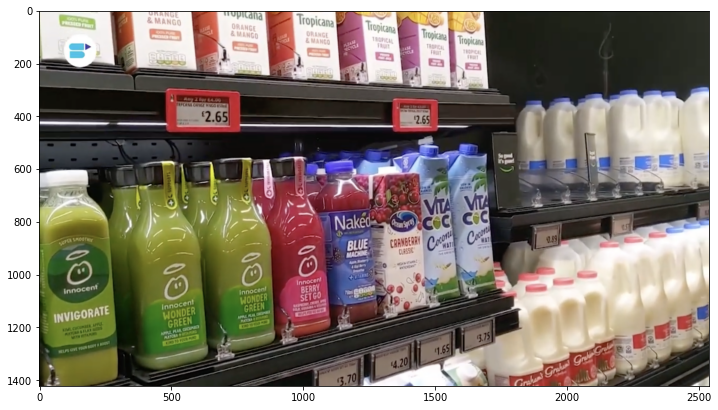

In [9]:
image = cv2.imread('./data/images/input/example/dairy_bottles.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12,8))
plt.grid(False)
plt.imshow(image)
plt.show()

In [10]:
width, height = 640, 480
dfImage, resizedImage = utils.loadImageAndConvertToDataframe('./data/images/input/example/dairy_bottles.png', width, height)

### Run Inference

With that done, we can have the model detect the objects on the image by running an inference through the pipeline, and storing the results for the next step.

**IMPORTANT NOTE**:  If necessary, add `timeout=60` to the `infer` method if more time is needed to upload the data file for the inference request.

In [14]:
startTime = time.time()
infResults = pipeline.infer(dfImage, timeout=300)
endTime = time.time()
infResults.loc[:, ['time', 'out.avg_conf']]

,time,out.avg_conf
0,2024-02-27 21:07:42.219,0.358804


### Draw the Inference Results

With our inference results, we can take them and use the Wallaroo CVDemo class and draw them onto the original image.  The bounding boxes and the confidence value will only be drawn on images where the model returned a 50% confidence rate in the object's identity.

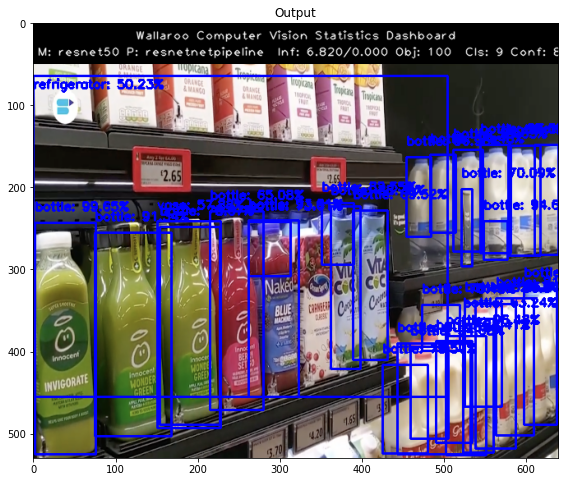

In [15]:
elapsed = 1.0
results = {
    'model_name' : model_name,
    'pipeline_name' : pipeline_name,
    'width': width,
    'height': height,
    'image' : resizedImage,
    'inf-results' : infResults,
    'confidence-target' : 0.50,
    'inference-time': (endTime-startTime),
    'onnx-time' : int(elapsed) / 1e+9,
    'classes_file': "./models/coco_classes.pickle",                 
    'color': 'BLUE'
}

image = utils.drawDetectedObjectsFromInference(results)

### Undeploy the Pipeline

With the inference complete, we can undeploy the pipeline and return the resources back to the Wallaroo instance.

In [16]:
pipeline.undeploy()

Waiting for undeployment - this will take up to 45s ..................................... ok


name,resnetnetpipeline
created,2024-02-27 20:40:50.671638+00:00
last_updated,2024-02-27 21:06:47.668045+00:00
deployed,False
arch,None
tags,
versions,"1bd78756-d89a-475e-a371-bab7b21bd3e0, ccbe13f5-a0a5-4289-a753-259d5556a3da, 4ad3b88f-854c-4113-8663-2f55a2537d17, 10bb5834-a20e-4d12-8749-a489d4d09783, 5cba1c57-8687-43bf-a9e6-ad048bf163ad, d5054ae3-284e-4680-aac3-f7974902f590, 8d347477-cead-4d5b-8dec-61a45b84db17"
steps,resnet50
published,False
